In [1]:
from typing import Optional, Callable

import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
from vector_spherical_harmonics import VectorSphericalSignal

In [2]:
def as_vector(r):
    """Converts an array to an `IrrepsArray` of irreps 1o."""
    if isinstance(r, jnp.ndarray):
        r = e3nn.IrrepsArray("1o", r)

    assert r.irreps == "1o"
    return r


def normalize(r):
    """Normalizes a vector."""
    r = as_vector(r)
    return r / jnp.linalg.norm(r.array, axis=-1, keepdims=True)


def Y_scalar(r, l):
    """Computes Y_l(r_hat) where r_hat is a unit vector along r."""
    r_hat = normalize(r)
    return e3nn.spherical_harmonics(l, r_hat, normalize=False, normalization="integral")

In [3]:
l = 1

r = e3nn.IrrepsArray("1o", jnp.array([1.0, 0.0, 0.0]))
print(jnp.linalg.norm(r.array) * e3nn.grad(Y_scalar, argnums=0)(r, l))

1x0e+1x1e+1x2e
[0.56418955 0.         0.         0.         0.         0.
 0.19947113 0.         0.34549412]


## Define Vector Spherical Harmonics

In [4]:
def Y(r, l):
    """First vector spherical harmonics."""
    r_hat = normalize(r)
    ys = Y_scalar(r_hat, l)
    return jax.vmap(lambda rc: rc * ys)(r_hat.array)


def Psi(r, l):
    """Second vector spherical harmonics."""
    r = as_vector(r)
    grad_ys = jax.jacobian(lambda r: Y_scalar(r, l).array)(r).array
    # Extra normalization factor of sqrt(l * (l + 1)) for Psi
    if l > 0:
        grad_ys = grad_ys / jnp.sqrt(l * (l + 1))

    r_norm = jnp.linalg.norm(r.array, axis=-1)
    psi = r_norm * grad_ys
    psi = jnp.transpose(psi, (-1, -2))
    psi = e3nn.IrrepsArray(e3nn.Irrep(l, (-1) ** (l + 1)), psi)
    return psi


def Phi(r, l):
    """Third vector spherical harmonics."""
    r = as_vector(r)
    grad_ys = jax.jacobian(lambda r: Y_scalar(r, l).array)(r).array
    # Extra normalization factor of sqrt(l * (l + 1)) for Psi
    if l > 0:
        grad_ys = grad_ys / jnp.sqrt(l * (l + 1))

    r = as_vector(r)
    phi = jax.vmap(jnp.cross, in_axes=(None, 0))(r.array, grad_ys)
    phi = jnp.transpose(phi, (-1, -2))
    phi = e3nn.IrrepsArray(e3nn.Irrep(l, (-1) ** (l)), phi)
    return phi

In [5]:
l = 2
r = jnp.asarray([1.0, 1.0, 0.0])
print(Y(r, l), Psi(r, l), Phi(r, l))

r = jnp.asarray([2.0, 0.0, 0.0])
print(Y(r, l), Psi(r, l), Phi(r, l))

1x2e
[[ 0.          0.3862741   0.11150773  0.         -0.19313705]
 [ 0.          0.3862741   0.11150773  0.         -0.19313705]
 [ 0.          0.          0.          0.         -0.        ]] 1x2o
[[ 0.0000000e+00 -6.8825514e-08 -2.7313706e-01  0.0000000e+00
  -1.5769573e-01]
 [ 0.0000000e+00 -6.8825514e-08  2.7313703e-01  0.0000000e+00
   1.5769579e-01]
 [ 3.1539151e-01  0.0000000e+00  0.0000000e+00  3.1539151e-01
   0.0000000e+00]] 1x2e
[[ 0.22301547  0.          0.          0.22301547  0.        ]
 [-0.22301547 -0.         -0.         -0.22301547 -0.        ]
 [ 0.          0.          0.3862741   0.          0.22301547]]
1x2e
[[ 0.         0.        -0.3153915  0.        -0.5462741]
 [ 0.         0.        -0.         0.        -0.       ]
 [ 0.         0.        -0.         0.        -0.       ]] 1x2o
[[0.         0.         0.         0.         0.        ]
 [0.         0.44603094 0.         0.         0.        ]
 [0.44603094 0.         0.         0.         0.        ]] 1x2e

## Plot Vector Spherical Harmonics

In [6]:
def create_vector_field(
    coeffs: e3nn.IrrepsArray,
    basis_fn: str,
    res_beta: int,
    res_alpha: int,
):
    """Creates a vector field from a set of coefficients and a choice of basis function."""
    try:
        func = {"Y": Y, "Psi": Psi, "Phi": Phi}[basis_fn]
    except KeyError:
        raise ValueError(f"Invalid basis {basis_fn}")

    # Create the signal
    sig = VectorSphericalSignal.from_function(
        lambda r: func(r, l=coeffs.irreps.lmax),
        res_beta=res_beta,
        res_alpha=res_alpha,
        quadrature="soft",
    )

    def linearly_combine_at_point(values):
        combined = jnp.einsum("...m,m->...", values.array, coeffs.array)
        return e3nn.IrrepsArray("1o", combined)

    sig = sig.apply(linearly_combine_at_point)
    assert sig.shape[-1] == 3

    return sig


def plot_vector_field(sig: VectorSphericalSignal):
    """Plots a vector field."""

    points = sig.grid_vectors
    vectors = sig.grid_values

    assert points.shape[-1] == 3
    assert vectors.shape[-1] == 3
    assert points.shape == vectors.shape

    points = points.reshape((-1, 3))
    vectors = vectors.reshape((-1, 3)).array

    fig = go.Figure()
    fig.add_trace(
        go.Cone(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            u=vectors[:, 0],
            v=vectors[:, 1],
            w=vectors[:, 2],
            anchor="tail",
            colorscale="Viridis",
            sizemode="scaled",
            sizeref=5,
            showscale=True,
        )
    )
    fig.update_layout(scene_aspectmode="data")
    return fig

In [7]:
l = 1

# Grid points on the sphere
for m in range(-l, l + 1):
    for func in ["Y", "Phi", "Psi"]:
        coeffs = e3nn.IrrepsArray(
            e3nn.s2_irreps(l)[-1],
            jnp.zeros(2 * l + 1).at[m + l].set(1),
        )
        sig = create_vector_field(
            coeffs=coeffs,
            basis_fn=func,
            res_beta=20,
            res_alpha=19,
        )
        fig = plot_vector_field(sig)
        fig.update_layout(title_text=rf"{func}: l = {l}, m = {m}")
        fig.show()

In [8]:
l = 2
y_coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(l)[-1], np.random.rand(2 * l + 1))
y_sig = create_vector_field(y_coeffs, basis_fn="Y", res_beta=20, res_alpha=19)

plot_vector_field(y_sig).show()

In [9]:
l = 2
psi_coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(l)[-1], np.random.rand(2 * l + 1))
psi_sig = create_vector_field(psi_coeffs, basis_fn="Psi", res_beta=20, res_alpha=19)

plot_vector_field(psi_sig).show()

In [10]:
l = 2
phi_coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(2)[-1], np.ones(2 * l + 1))
phi_sig = create_vector_field(phi_coeffs, basis_fn="Phi", res_beta=20, res_alpha=19)

plot_vector_field(phi_sig).show()

In [11]:
y_cross_psi = y_sig.cross(psi_sig)
plot_vector_field(y_cross_psi).show()

In [12]:
y_sig.grid_values.irreps, psi_sig.grid_values.irreps, phi_sig.grid_values.irreps, y_cross_psi.grid_values.irreps

(1x1o, 1x1o, 1x1o, 1x1e)

In [13]:
phi_dot_y_cross_psi = phi_sig.dot(y_cross_psi)
phi_dot_y_cross_psi_coeffs = e3nn.from_s2grid(
    phi_dot_y_cross_psi, irreps=e3nn.s2_irreps(2 * l)
)
for ir, coeff in zip(
    phi_dot_y_cross_psi_coeffs.irreps, phi_dot_y_cross_psi_coeffs.chunks
):
    print(ir, coeff.round(2))

go.Figure([go.Surface(phi_dot_y_cross_psi.plotly_surface())]).show()

ValueError: Dot product is only defined for IrrepsArray with the same irreps.

seems sus so let's check orthogonality properties...

## Check Orthogonality of Scalar Spherical Harmonics

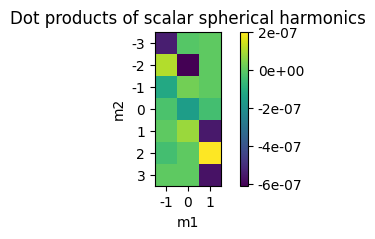

In [ ]:
def create_scalar_field(coeffs: e3nn.IrrepsArray, res_beta: int, res_alpha: int):
    return e3nn.to_s2grid(
        coeffs,
        res_beta=res_beta,
        res_alpha=res_alpha,
        quadrature="soft",
        p_val=1,
        p_arg=-1,
    )


l1 = 1
l2 = 3
dot_prods = np.zeros((2 * l1 + 1, 2 * l2 + 1))

for m1 in range(-l1, l1 + 1):
    for m2 in range(-l2, l2 + 1):

        # Check orthogonality of scalar spherical harmonics
        coeffs_scalar_1 = e3nn.IrrepsArray(
            e3nn.s2_irreps(l1)[-1], jnp.zeros(2 * l1 + 1).at[m1 + l1].set(1)
        )
        sig_scalar_1 = create_scalar_field(coeffs_scalar_1, res_beta=20, res_alpha=19)

        coeffs_scalar_2 = e3nn.IrrepsArray(
            e3nn.s2_irreps(l2)[-1], jnp.zeros(2 * l2 + 1).at[m2 + l2].set(1)
        )
        sig_scalar_2 = create_scalar_field(coeffs_scalar_2, res_beta=20, res_alpha=19)

        dot_prods[m1, m2] = (sig_scalar_1 * sig_scalar_2).integrate().array.item()

plt.figure(figsize=(5, 2))
plt.imshow(dot_prods.T)
plt.xlabel("m1")
plt.ylabel("m2")
plt.xticks(ticks=range(2 * l1 + 1), labels=range(-l1, l1 + 1))
plt.yticks(ticks=range(2 * l2 + 1), labels=range(-l2, l2 + 1))
plt.title("Dot products of scalar spherical harmonics")
plt.colorbar(format="%.0e")
plt.show()

## Check Orthogonality of Vector Spherical Harmonics

So the scalar spherical harmonics are clearly orthogonal.
What about the vector ones?

In [ ]:
basis_fn1 = "Phi"
l1 = 3
basis_fn2 = "Phi"
l2 = 3
dot_prods = np.zeros((2 * l1 + 1, 2 * l2 + 1))

for m1 in range(-l1, l1 + 1):
    for m2 in range(-l2, l2 + 1):

        # Check orthogonality of vector spherical harmonics
        coeffs_vector_1 = e3nn.IrrepsArray(
            e3nn.s2_irreps(l1)[-1], jnp.zeros(2 * l1 + 1).at[m1 + l1].set(1)
        )
        _, vectors_1 = create_vector_field(
            coeffs_vector_1, basis_fn=basis_fn1, res_beta=20, res_alpha=19
        )

        coeffs_vector_2 = e3nn.IrrepsArray(
            e3nn.s2_irreps(l2)[-1], jnp.zeros(2 * l2 + 1).at[m2 + l2].set(1)
        )
        _, vectors_2 = create_vector_field(
            coeffs_vector_2, basis_fn=basis_fn2, res_beta=20, res_alpha=19
        )

        # Compute dot product.
        dot_product = jnp.einsum("...i,...i->...", vectors_1, vectors_2)
        dot_product_sig = e3nn.SphericalSignal(
            grid_values=dot_product,
            quadrature="soft",
        )
        dot_prods[m1, m2] = dot_product_sig.integrate().array.item()

print(dot_prods)
plt.imshow(dot_prods.T)
plt.xlabel(f"{basis_fn1}: m1")
plt.ylabel(f"{basis_fn2}: m2")
plt.xticks(ticks=range(2 * l1 + 1), labels=range(-l1, l1 + 1))
plt.yticks(ticks=range(2 * l2 + 1), labels=range(-l2, l2 + 1))
plt.title("Dot products of vector spherical harmonics")
plt.colorbar(format="%.d")
plt.show()

TypeError: cannot unpack non-iterable VectorSphericalSignal object

## Check Cross Product Coefficients

In [ ]:
for l_input in [1]:
    for l_output in [0, 1, 2, 3]:
        for basis_1 in ["Y", "Psi", "Phi"]:
            for basis_2 in ["Y", "Psi", "Phi"]:
                if basis_1 < basis_2:
                    continue
                for basis_3 in ["Y", "Psi", "Phi"]:

                    # First signal
                    coeffs_1 = e3nn.IrrepsArray(
                        e3nn.s2_irreps(l_input)[-1], np.random.rand(2 * l_input + 1)
                    )
                    points, values_1 = create_vector_field(
                        coeffs_1, basis_fn=basis_1, res_beta=20, res_alpha=19
                    )

                    # Second signal
                    coeffs_2 = e3nn.IrrepsArray(
                        e3nn.s2_irreps(l_input)[-1], np.random.rand(2 * l_input + 1)
                    )
                    points, values_2 = create_vector_field(
                        coeffs_2, basis_fn=basis_2, res_beta=20, res_alpha=19
                    )

                    # Third signal
                    coeffs_3 = e3nn.IrrepsArray(
                        e3nn.s2_irreps(l_output)[-1], np.ones(2 * l_output + 1)
                    )
                    points, values_3 = create_vector_field(
                        coeffs_3,
                        basis_fn=basis_3,
                        res_beta=20,
                        res_alpha=19,
                    )

                    # Compute the dot product of (cross product of the first two signals) and the third signal
                    cross_product = jnp.cross(values_1, values_2)

                    dot_product = jnp.einsum("...i,...i->...", cross_product, values_3)
                    sig = e3nn.SphericalSignal(
                        grid_values=dot_product,
                        quadrature="soft",
                    )
                    coeffs = e3nn.from_s2grid(sig, irreps=e3nn.s2_irreps(l_output)[-1])
                    if np.abs(coeffs.array).max() < 1e-6:
                        continue

                    print(
                        f"({basis_1}^{l_input} x {basis_2}^{l_input}) . {basis_3}^{l_output} is non-zero: {np.abs(coeffs.array).max()}"
                    )

(Psi^1 x Phi^1) . Y^0 is non-zero: 0.016644667834043503
(Y^1 x Psi^1) . Phi^1 is non-zero: 0.007063513156026602
(Y^1 x Phi^1) . Psi^1 is non-zero: 0.039089299738407135
(Psi^1 x Phi^1) . Y^1 is non-zero: 0.003418771317228675
(Y^1 x Psi^1) . Phi^2 is non-zero: 0.014225369319319725
(Y^1 x Phi^1) . Psi^2 is non-zero: 0.02296331711113453
(Psi^1 x Phi^1) . Y^2 is non-zero: 0.02272769808769226
(Y^1 x Psi^1) . Phi^3 is non-zero: 0.008714471943676472
(Y^1 x Phi^1) . Psi^3 is non-zero: 0.00670225964859128
(Psi^1 x Phi^1) . Y^3 is non-zero: 0.01299859955906868


# Check Equivariance

Each of Y, Phi and Psi should transform as:

$R Y^l_m(Rx) = \sum_{m'} D^l_{m, m'}(R) Y(x)$

or, accumulating over m:

$R Y^l(Rx) = D^l(R) Y(x)$

where $D^l(R)$ is the Wigner D matrix.

First, let's show this for the scalar spherical harmonics, where:

$Y^l(Rx) = D^l(R) Y(x)$


In [ ]:
# Check the equivariance of scalar Y.
l = 2

# Example x.
x = jnp.asarray([1.0, 2.0, 3.0])
x_hat = x / jnp.linalg.norm(x)

# Example rotation R.
angles = np.random.rand(3)
R = e3nn.angles_to_matrix(*angles)
ir = e3nn.Irrep(l=l, p=(-1) ** l)
DR = ir.D_from_matrix(R)

rotated = Y_scalar(R @ x_hat, l).array
expected = Y_scalar(x_hat, l).array @ DR.T
assert np.allclose(rotated, expected, atol=1e-6), (rotated - expected).round(2)

This seems good!

In [ ]:
# Check the equivariance of vector Y, Psi, and Phi.
l = 3

# Example x.
x = jnp.asarray([1.0, 2.0, 3.0])
x_hat = x / jnp.linalg.norm(x)

for basis_fn in [Y, Phi, Psi]:
    # Example rotation R.
    angles = np.random.rand(3)
    R = e3nn.angles_to_matrix(*angles)
    ir = e3nn.Irrep(l=l, p=(-1) ** l)
    DR = ir.D_from_matrix(R)

    rotated = basis_fn(R @ x_hat, l).array
    expected = R @ basis_fn(x_hat, l).array @ DR.T
    assert np.allclose(rotated, expected, atol=1e-6), (rotated - expected).round(2)